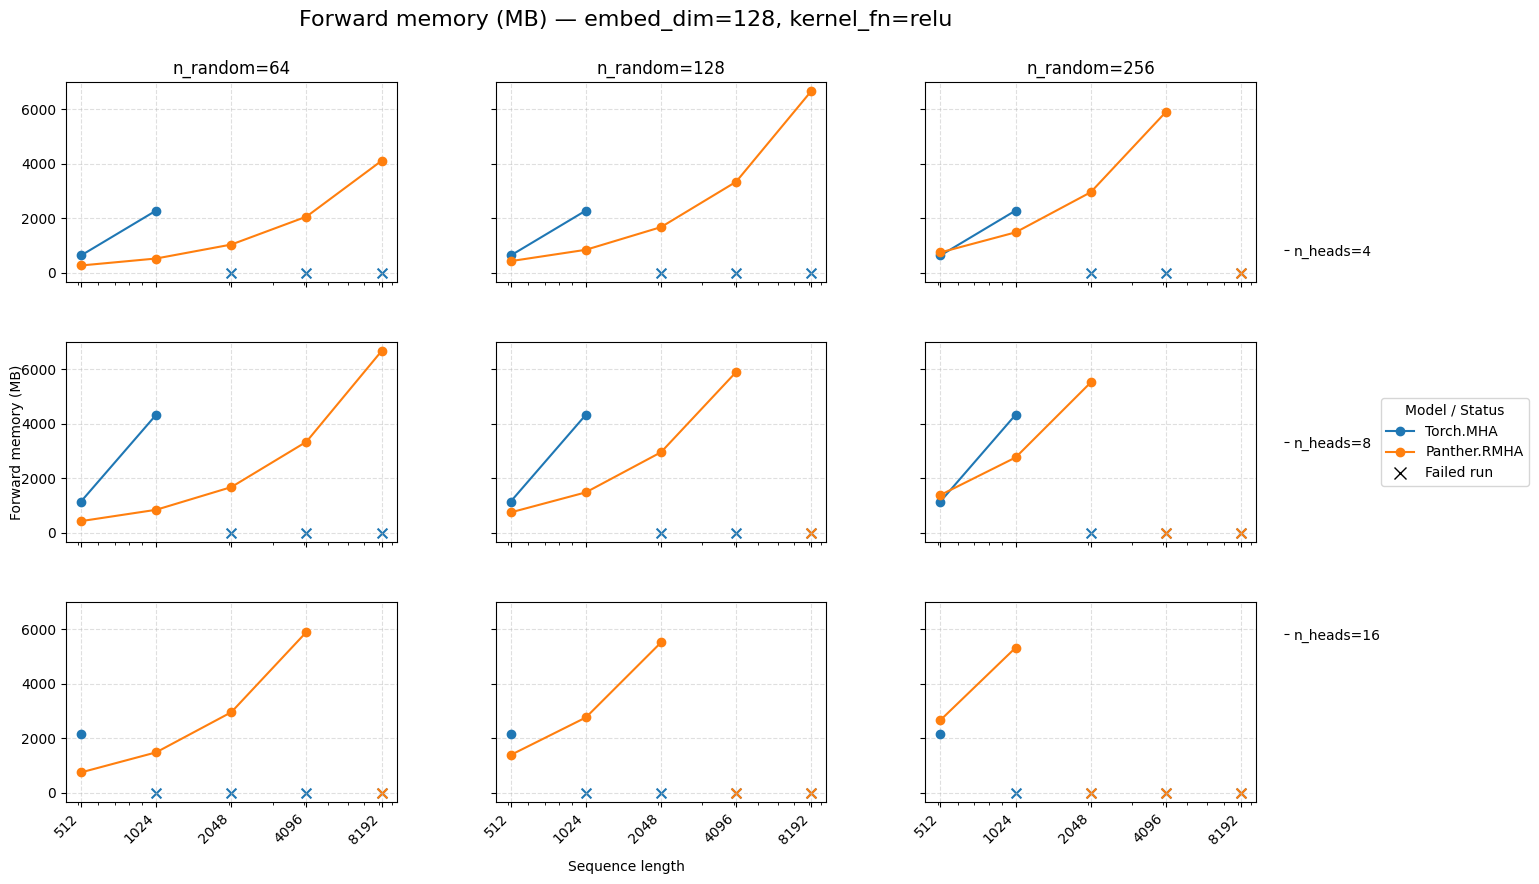

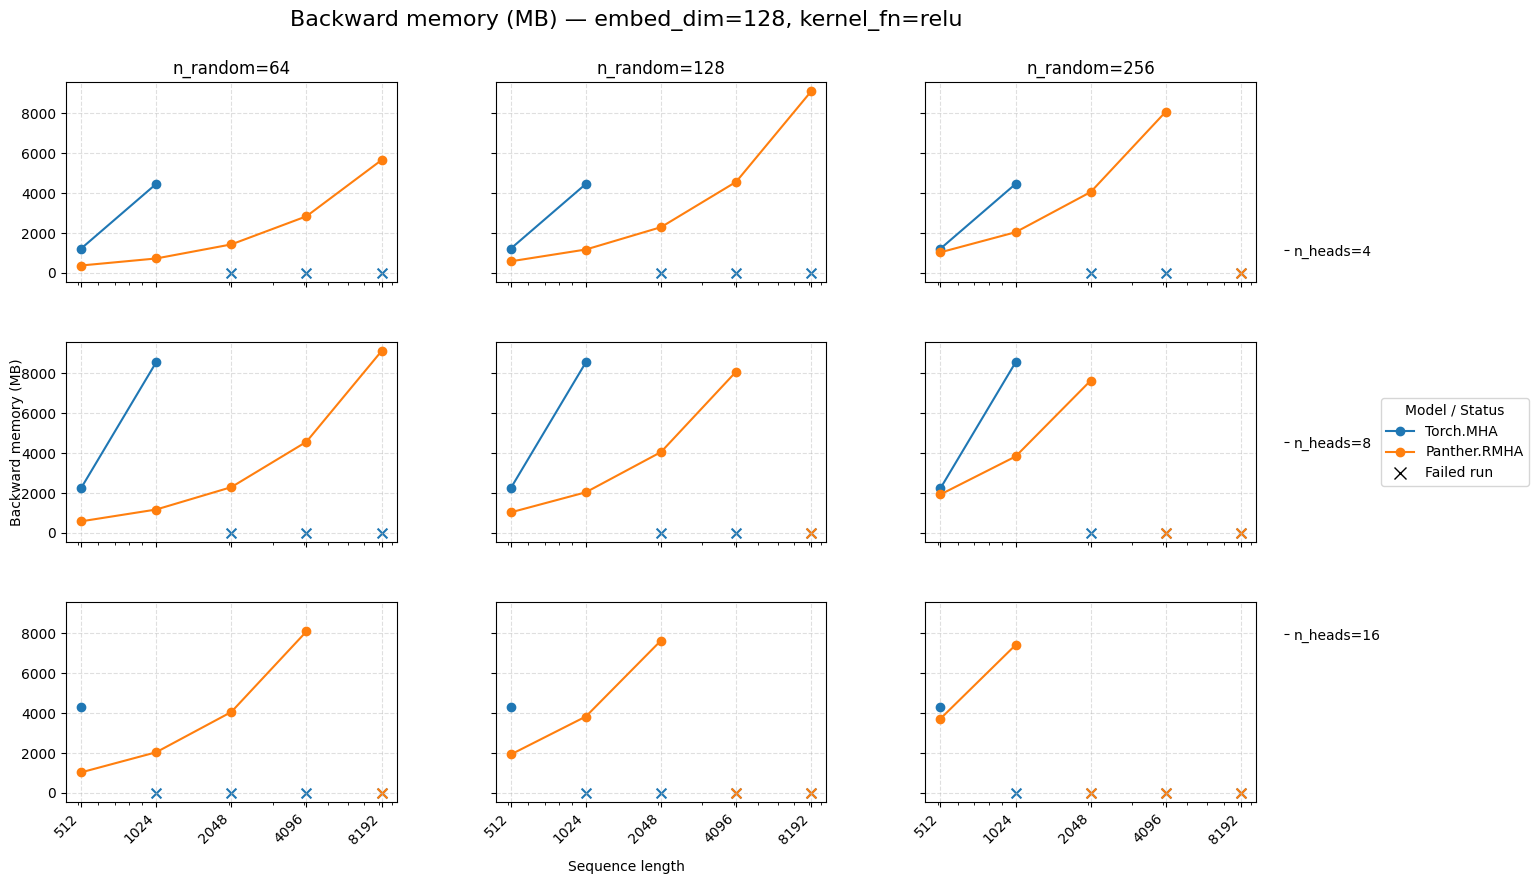

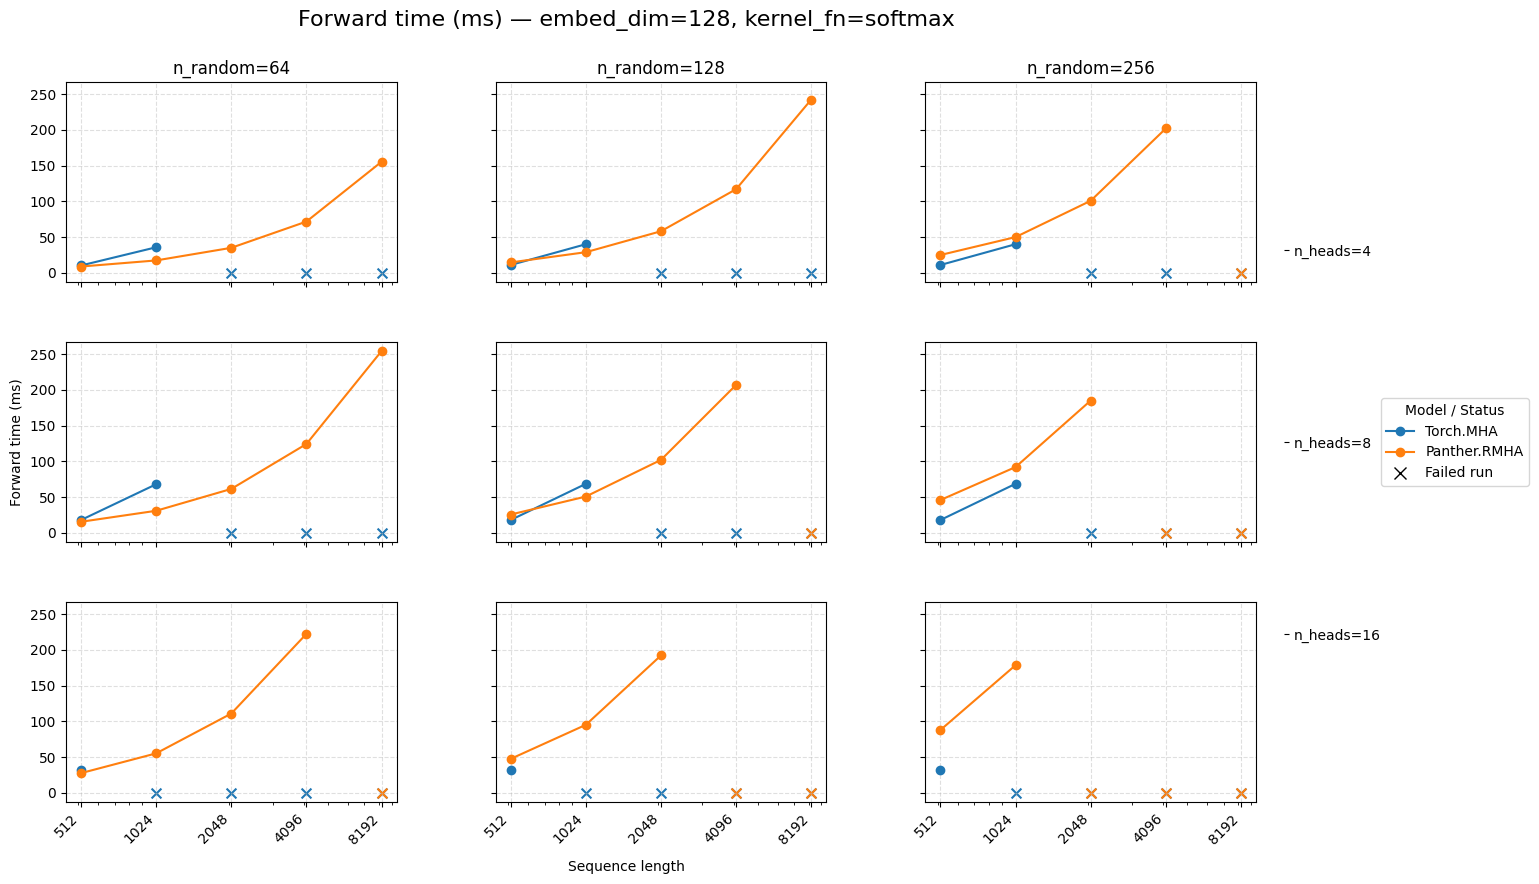

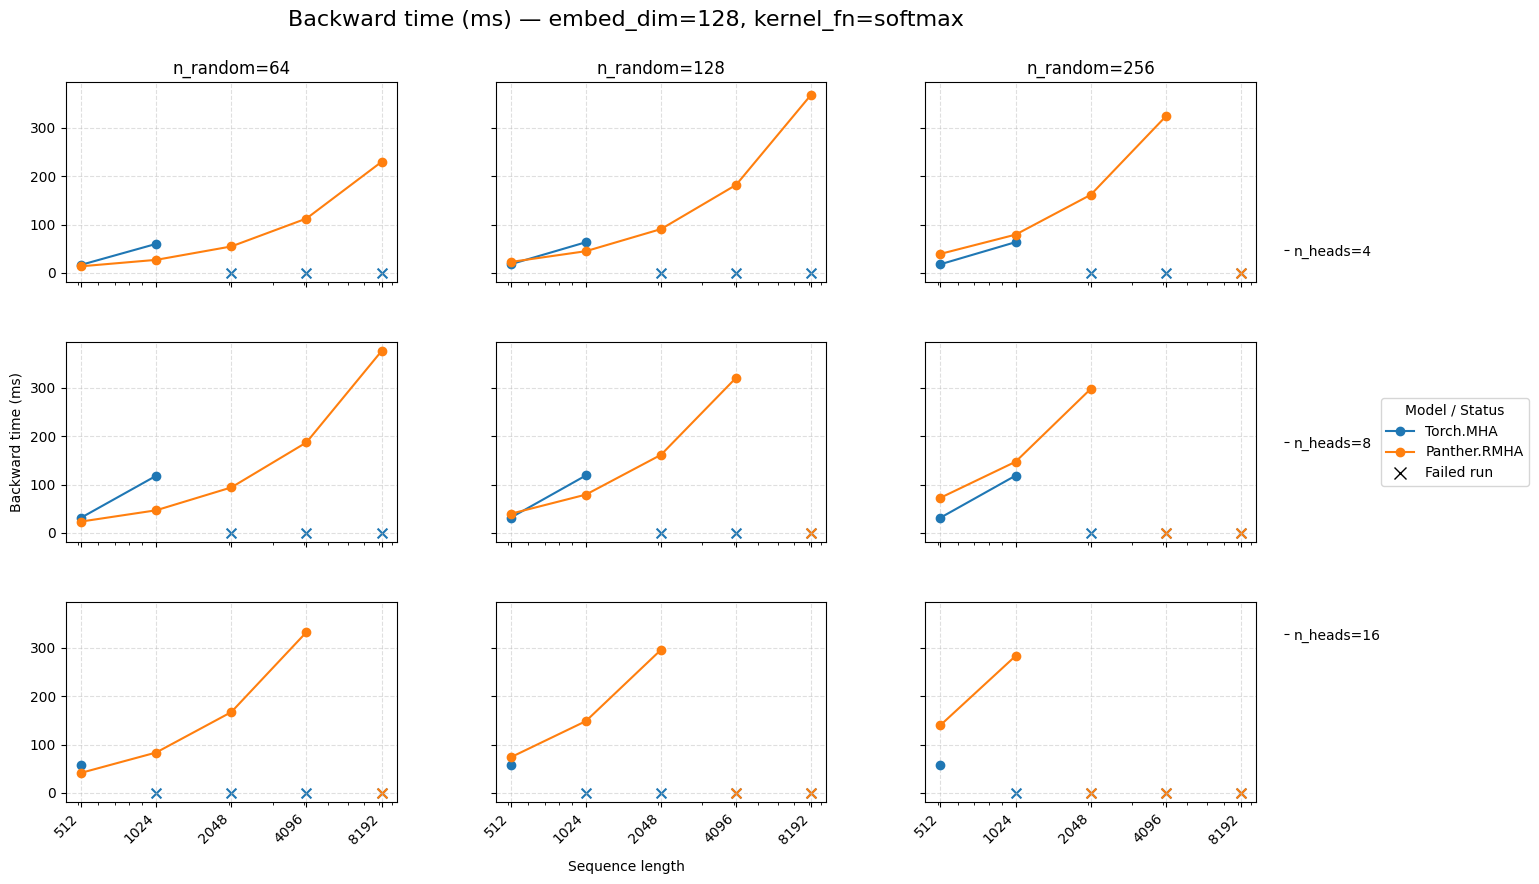

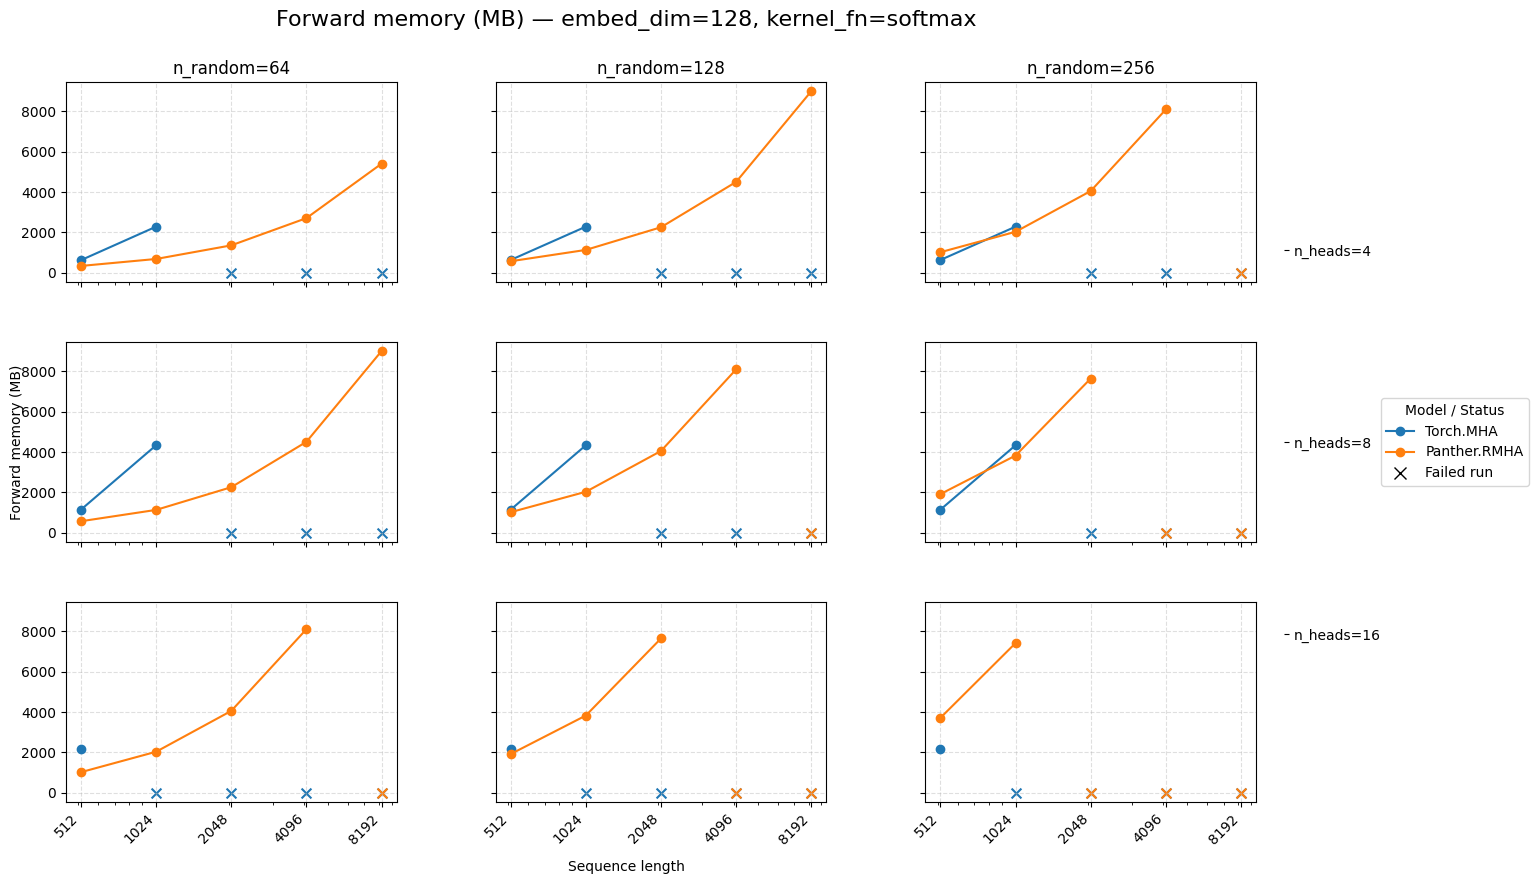

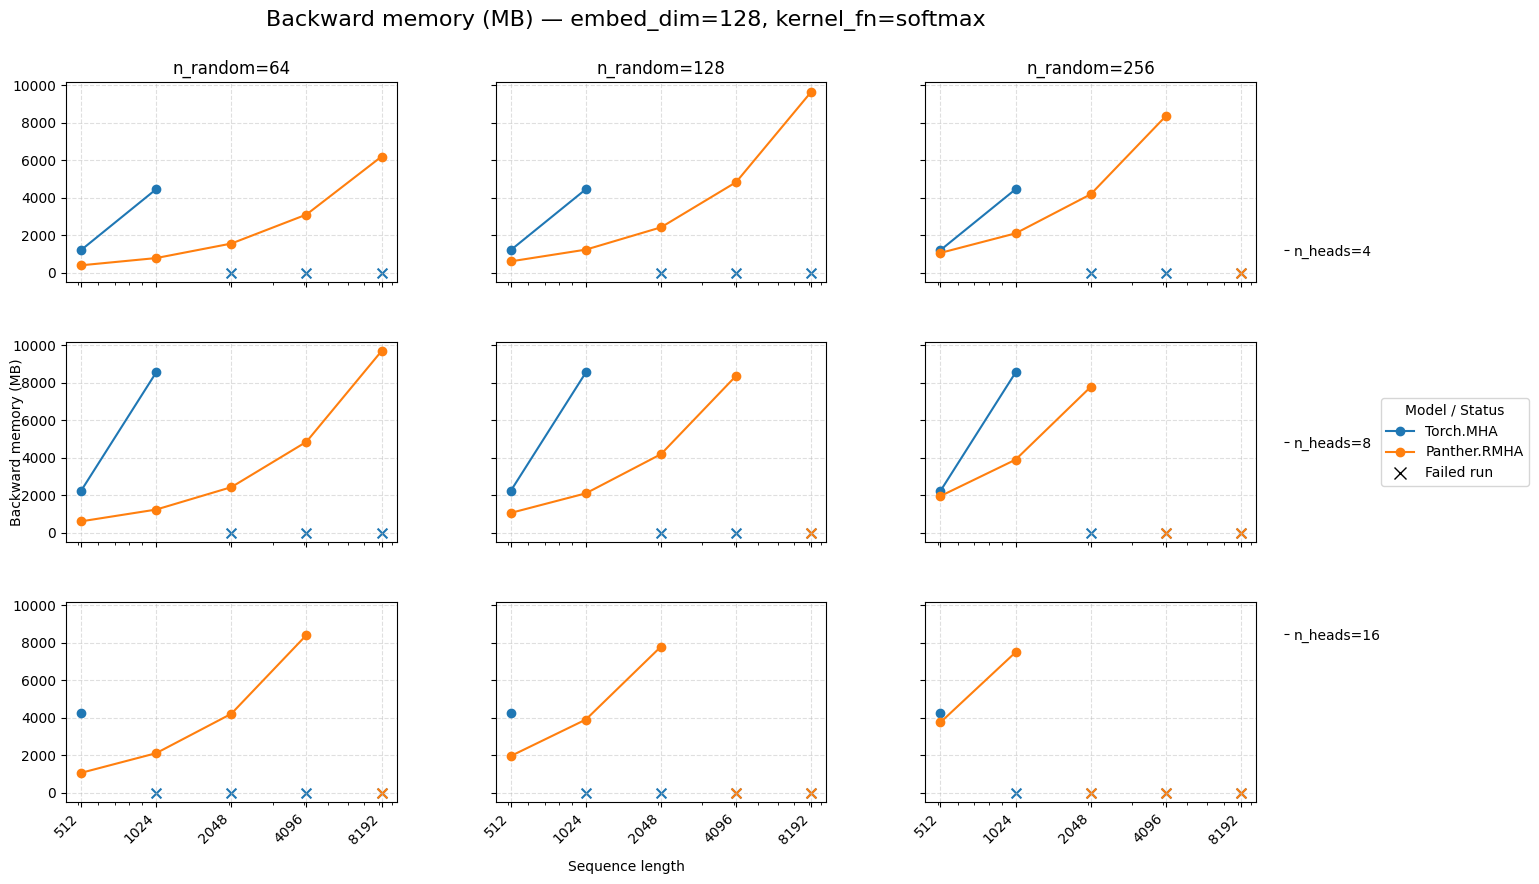

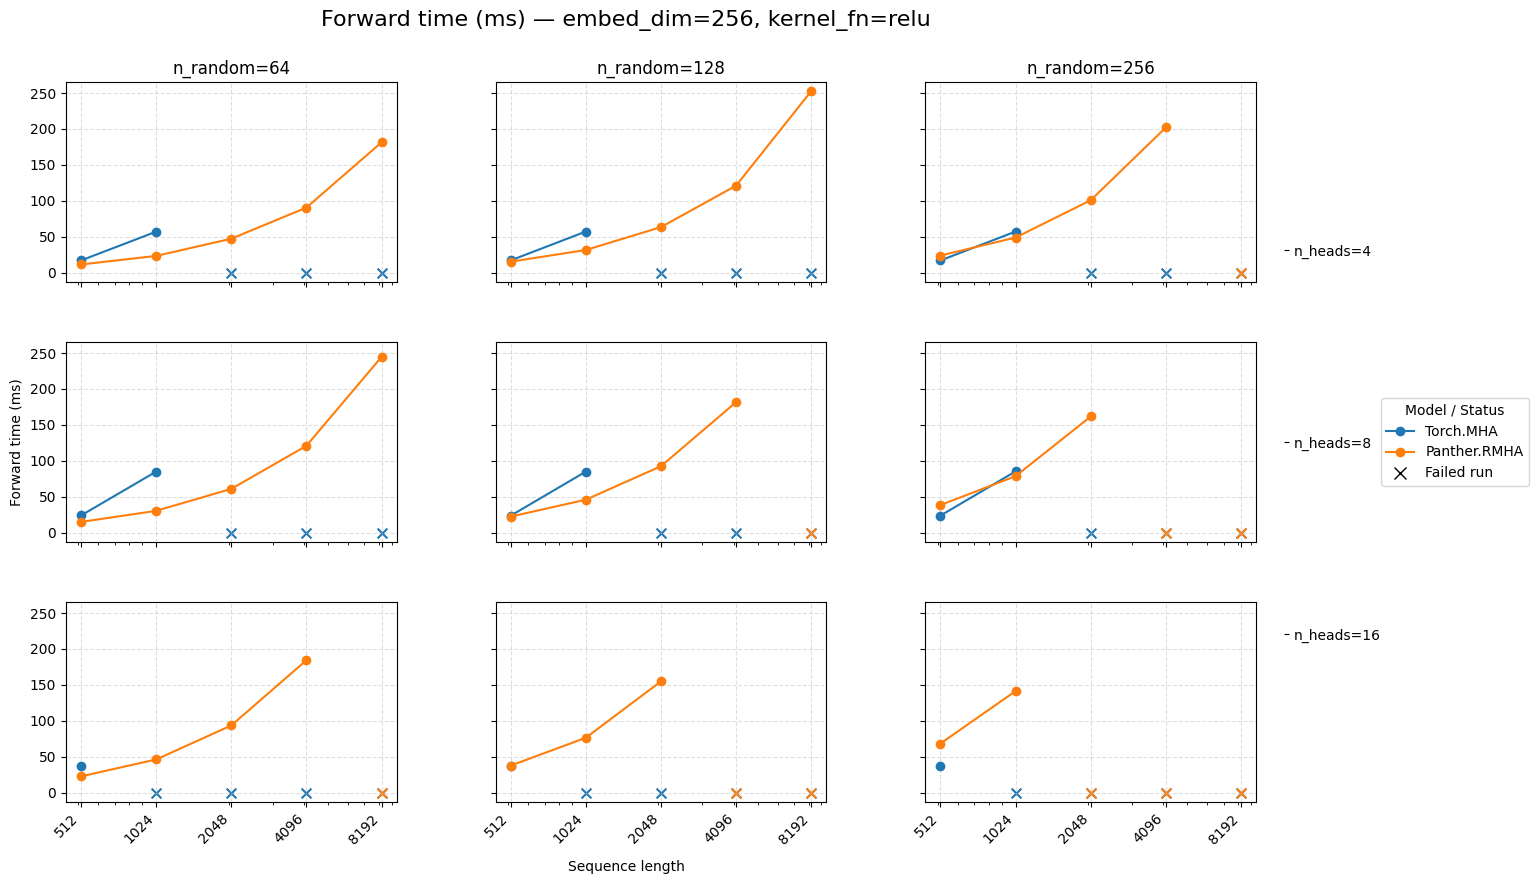

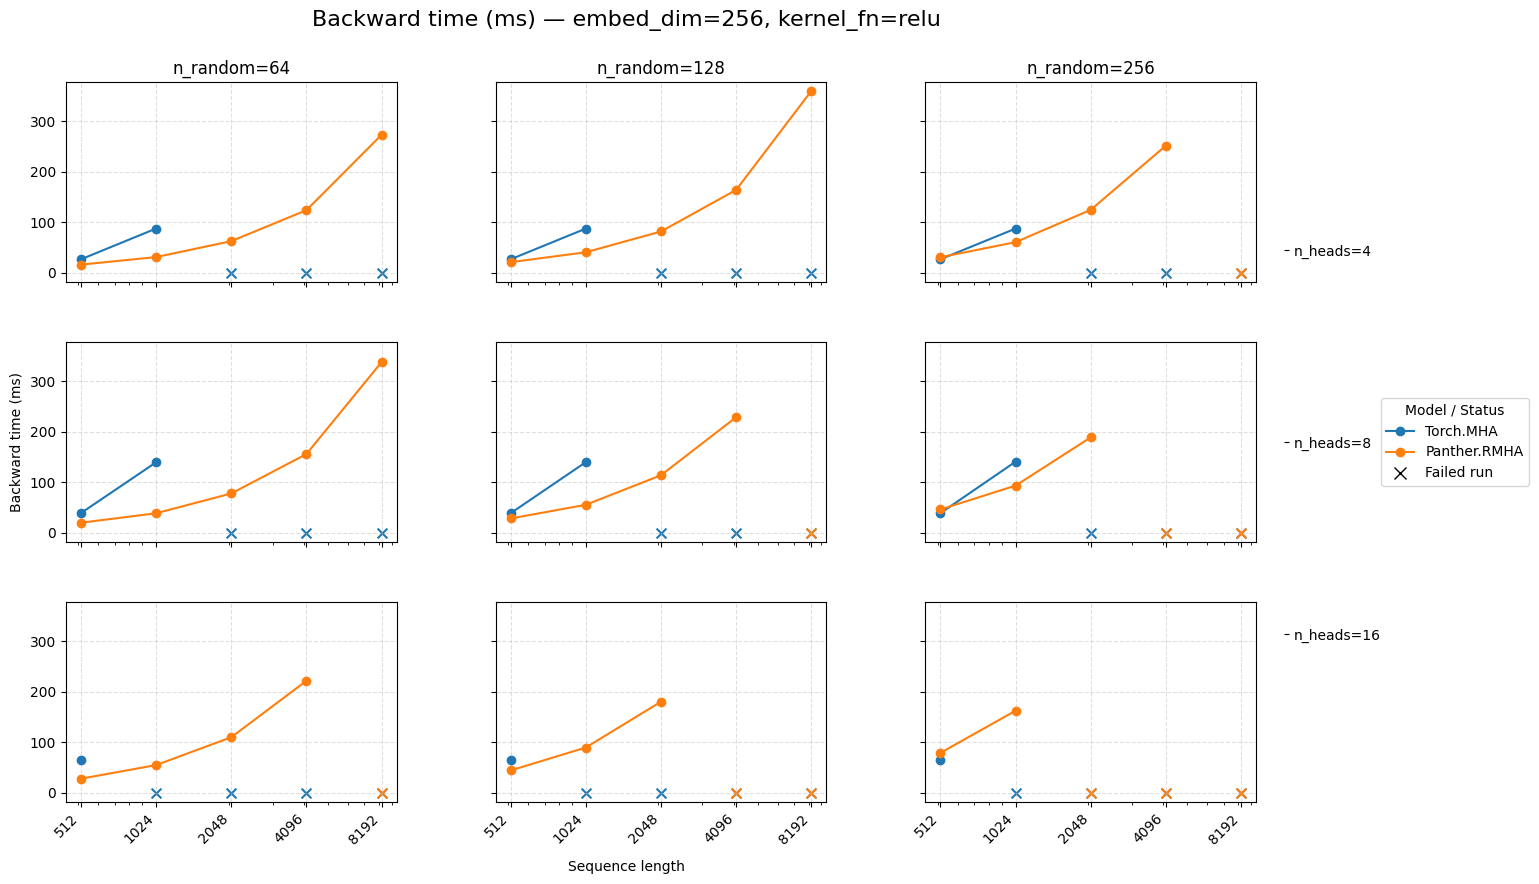

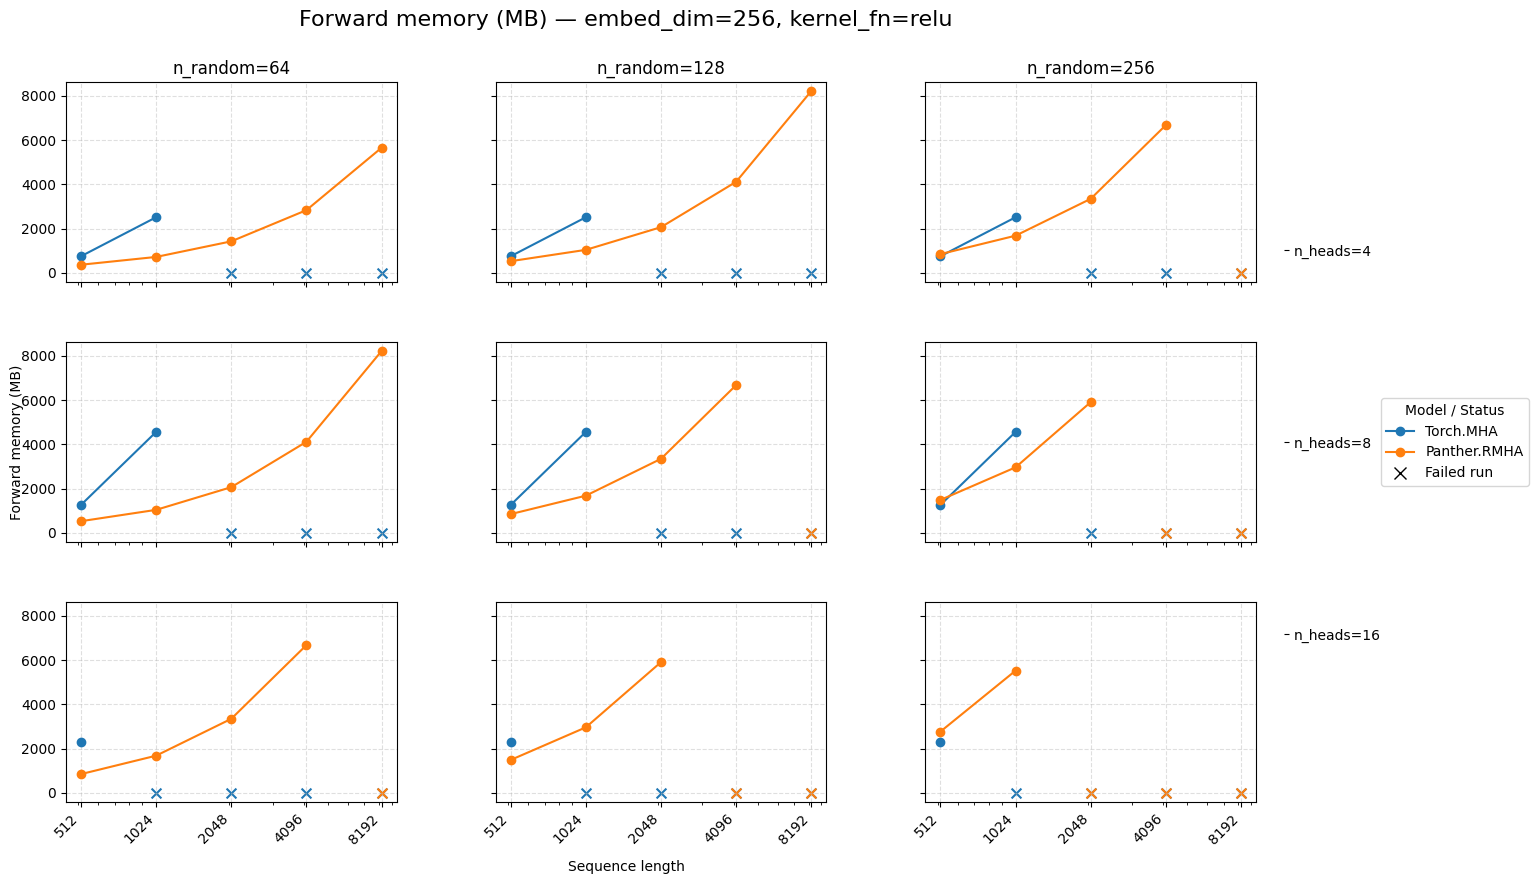

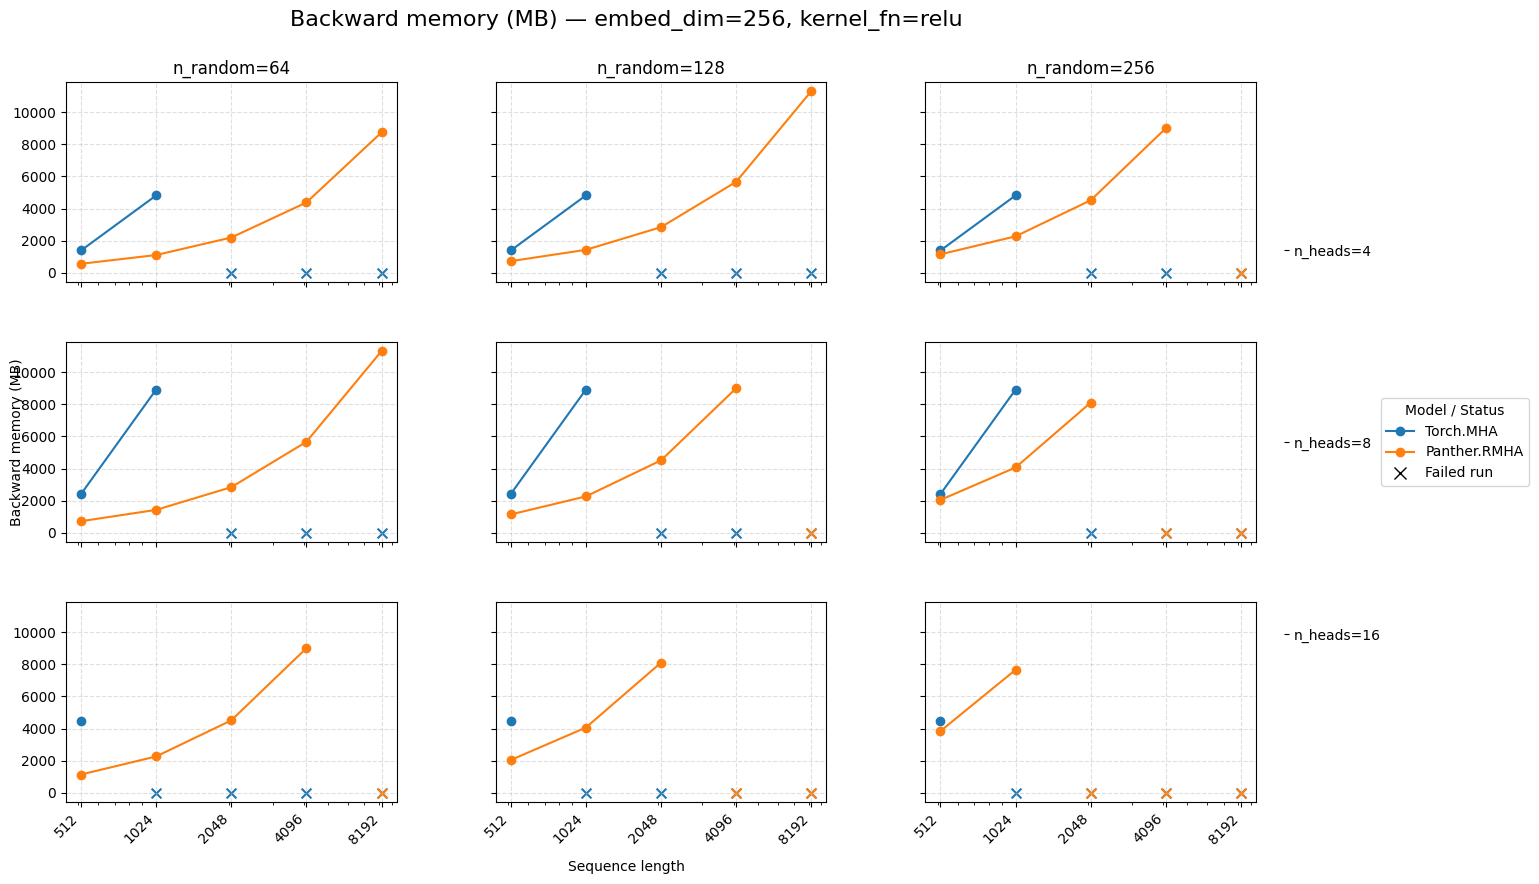

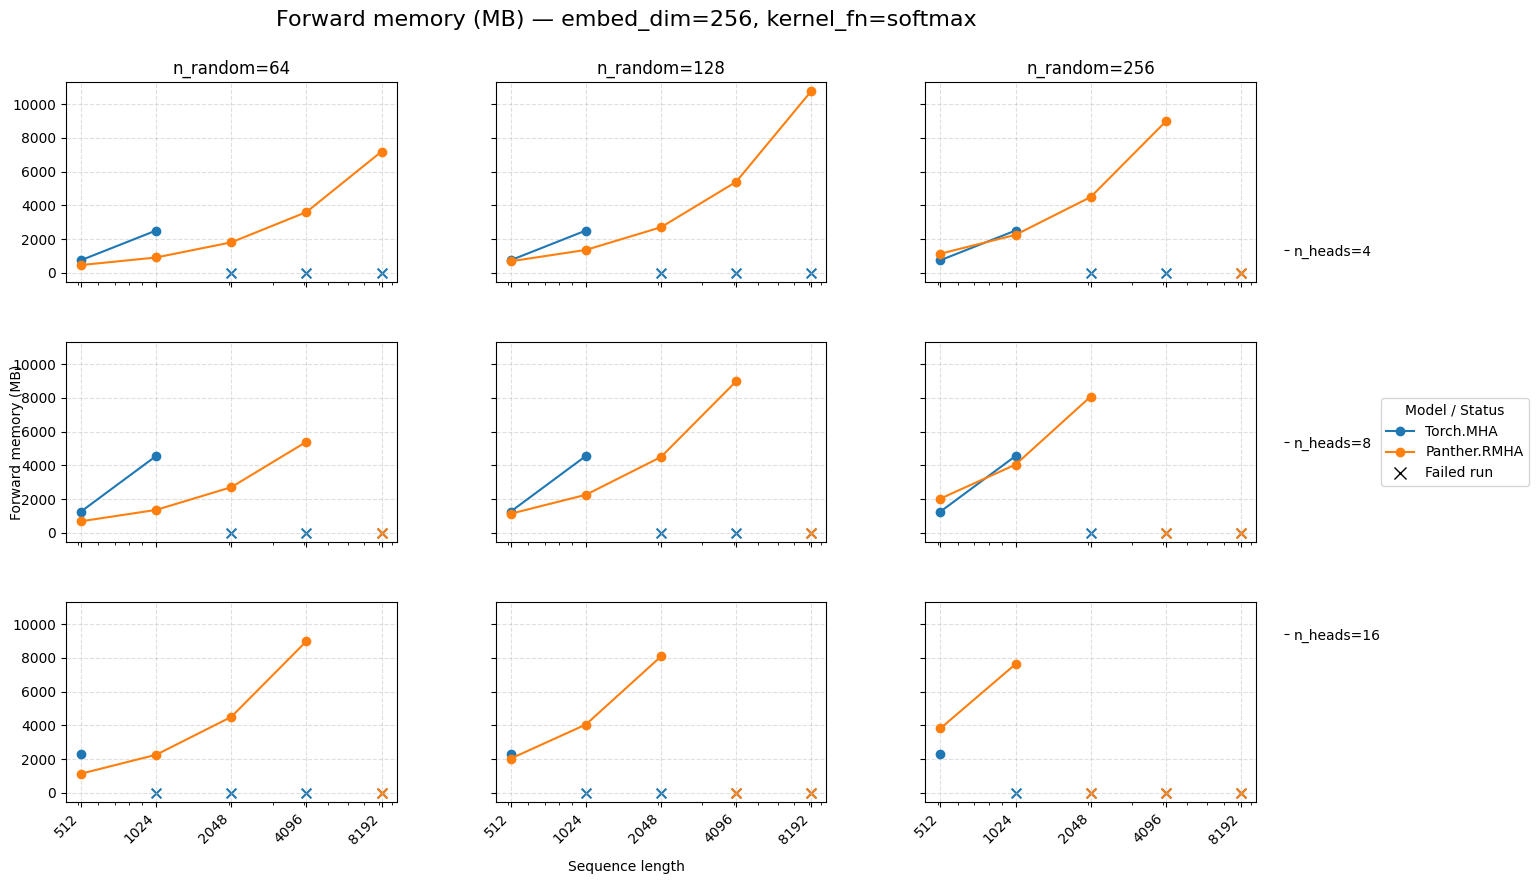

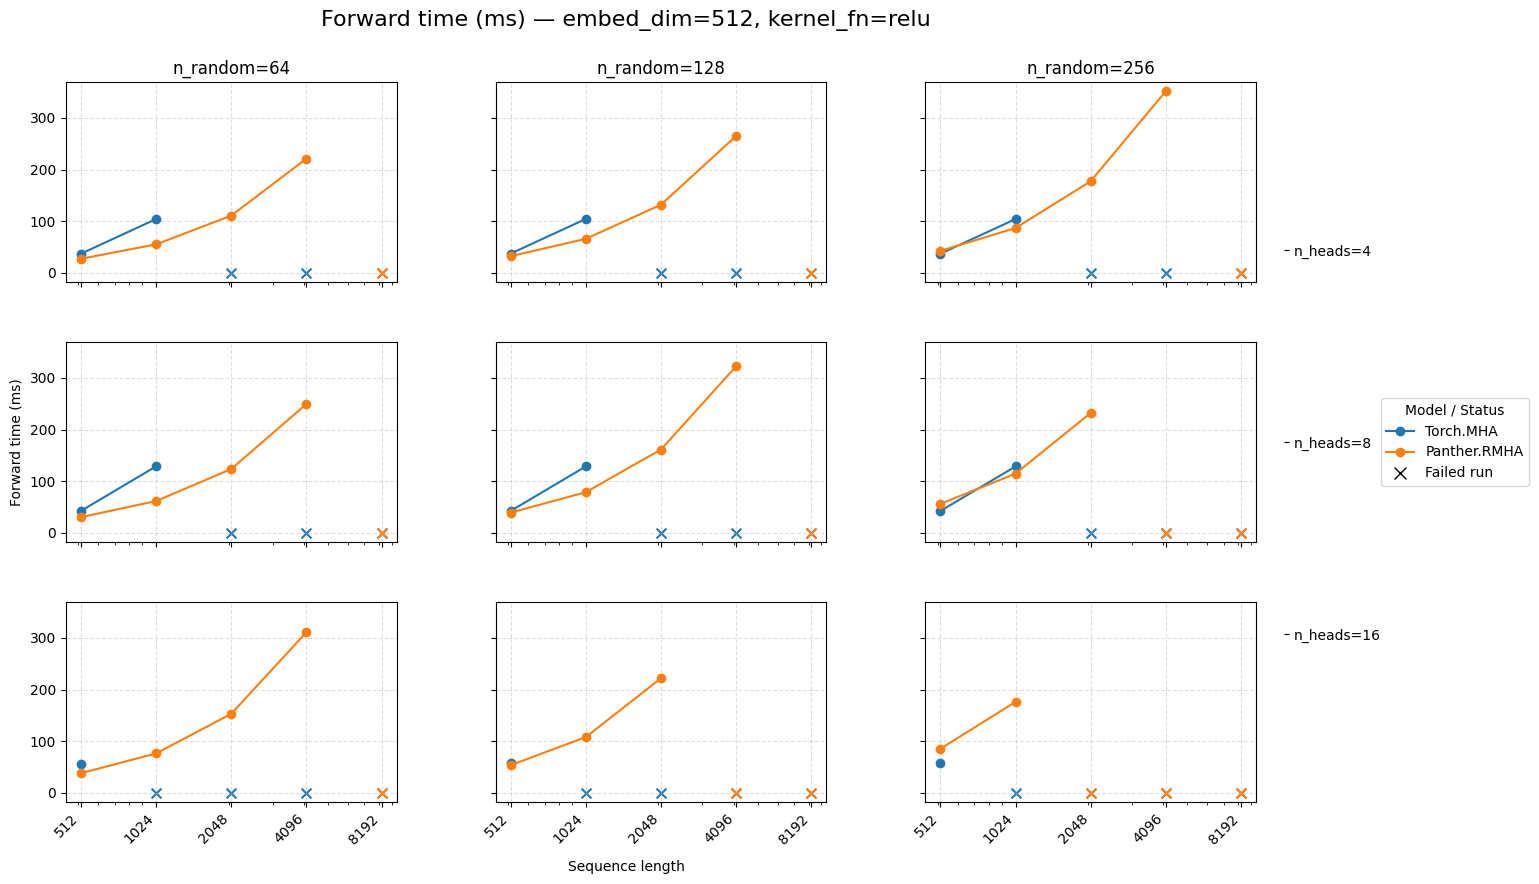

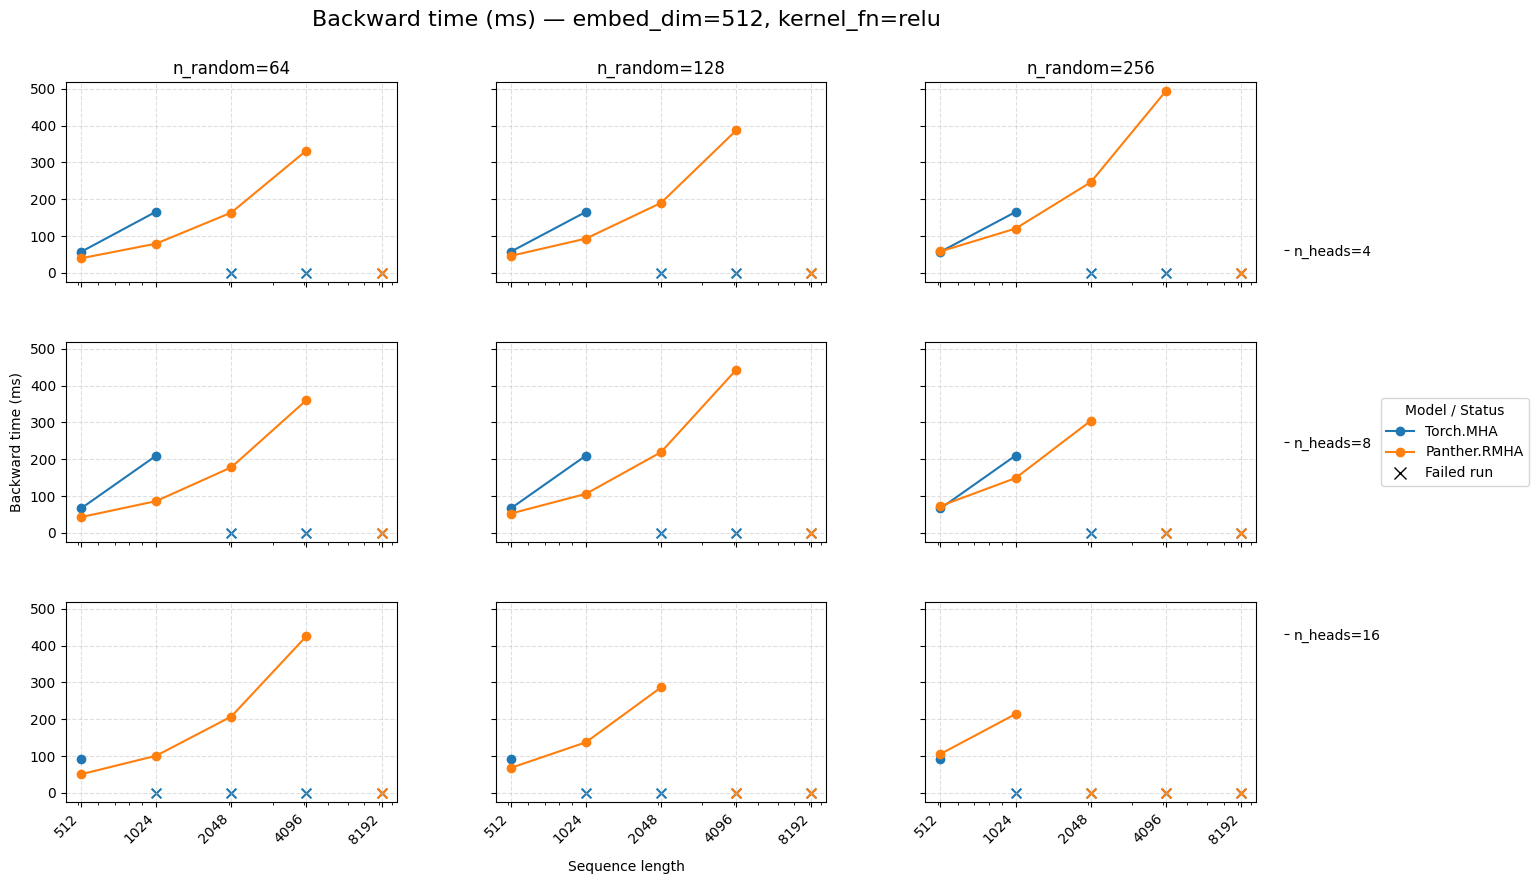

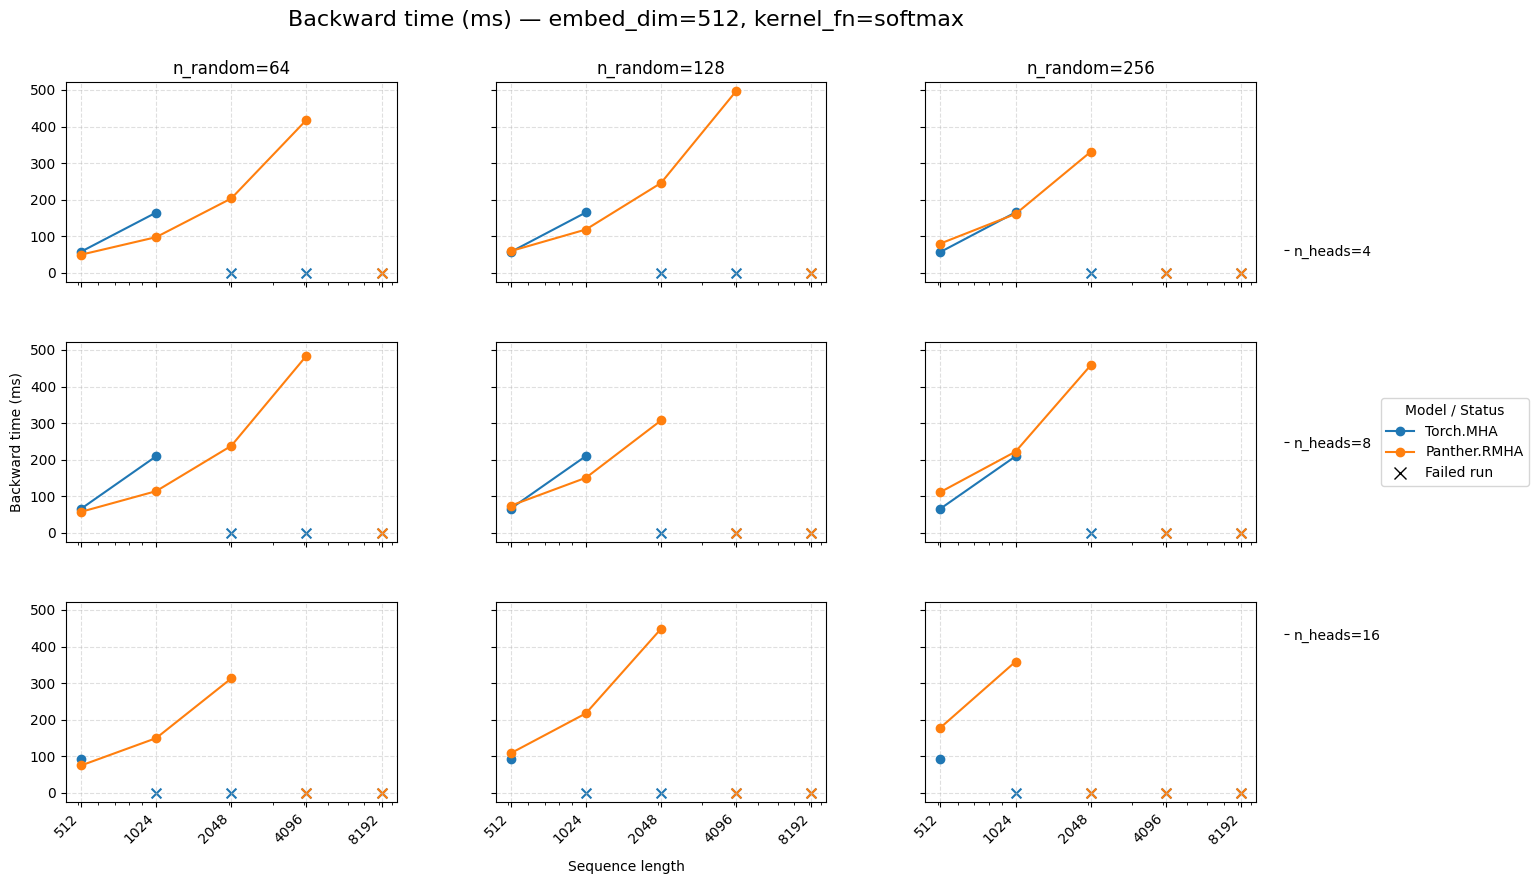

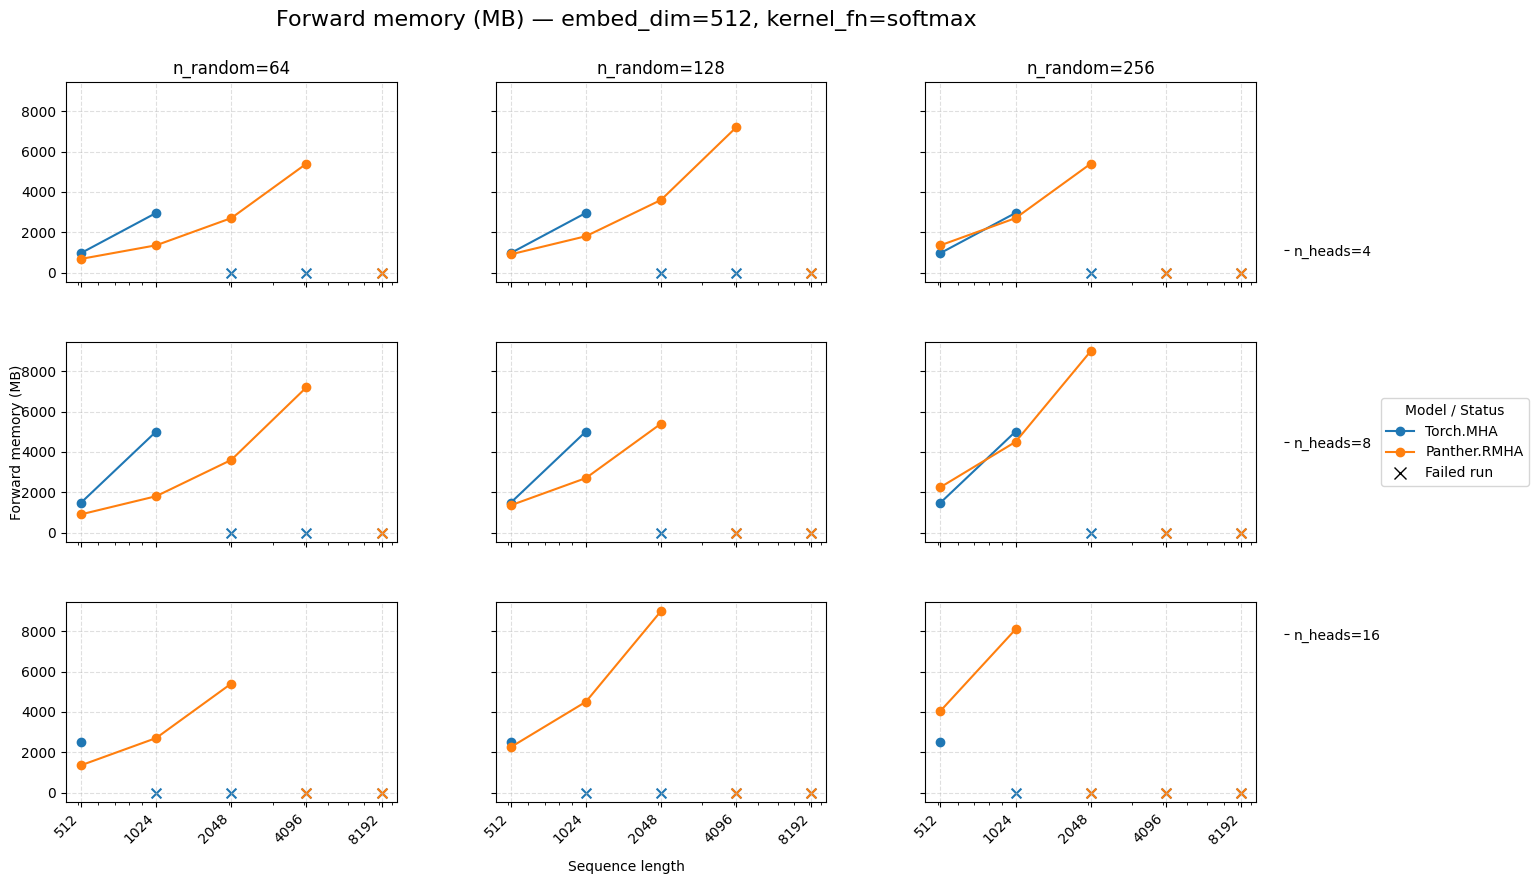

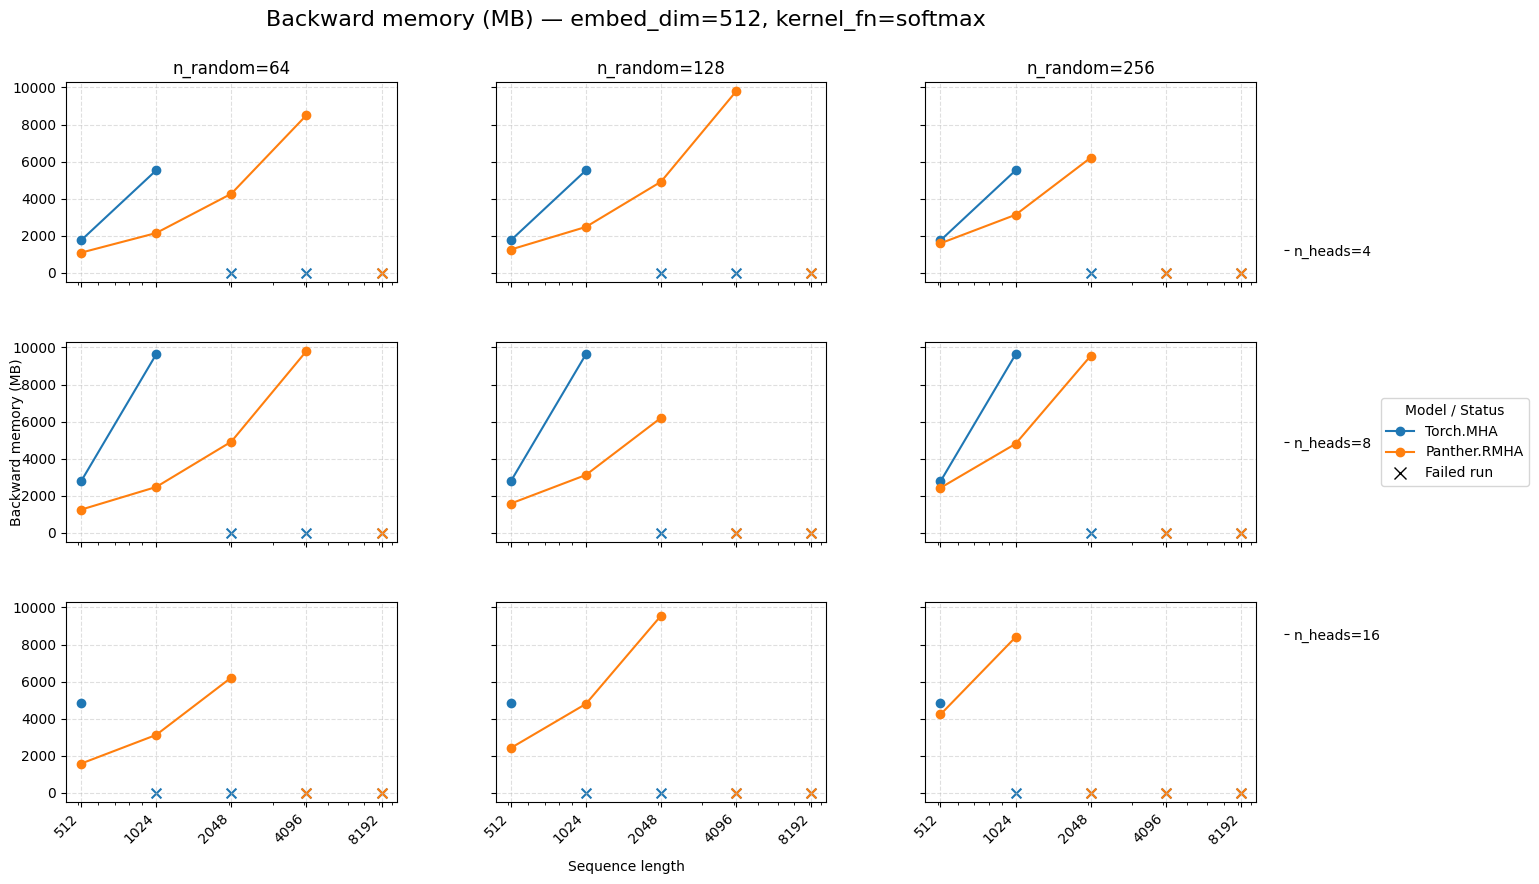

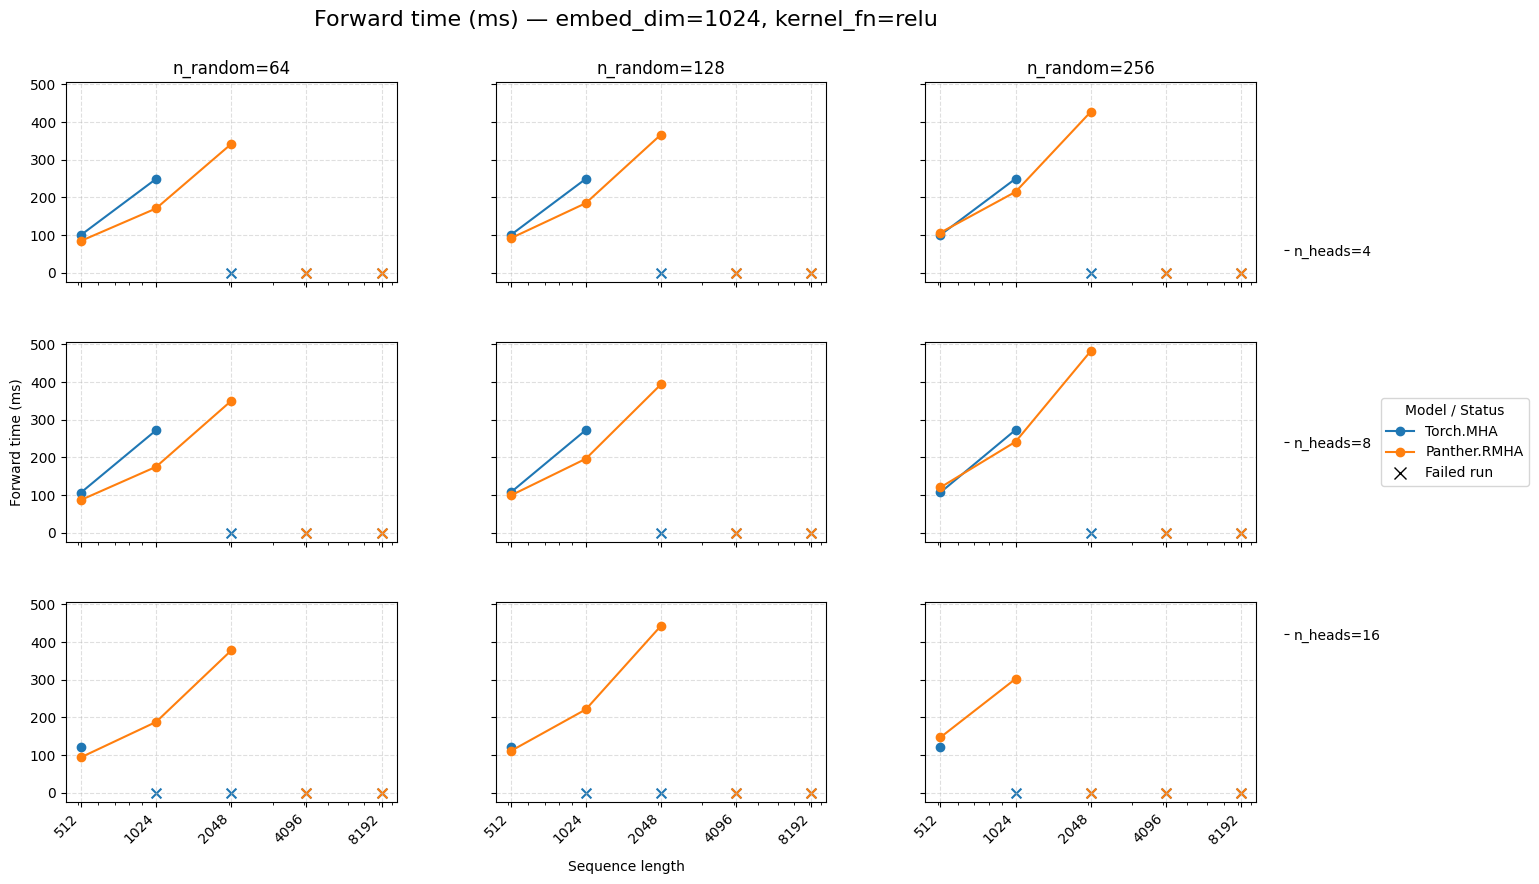

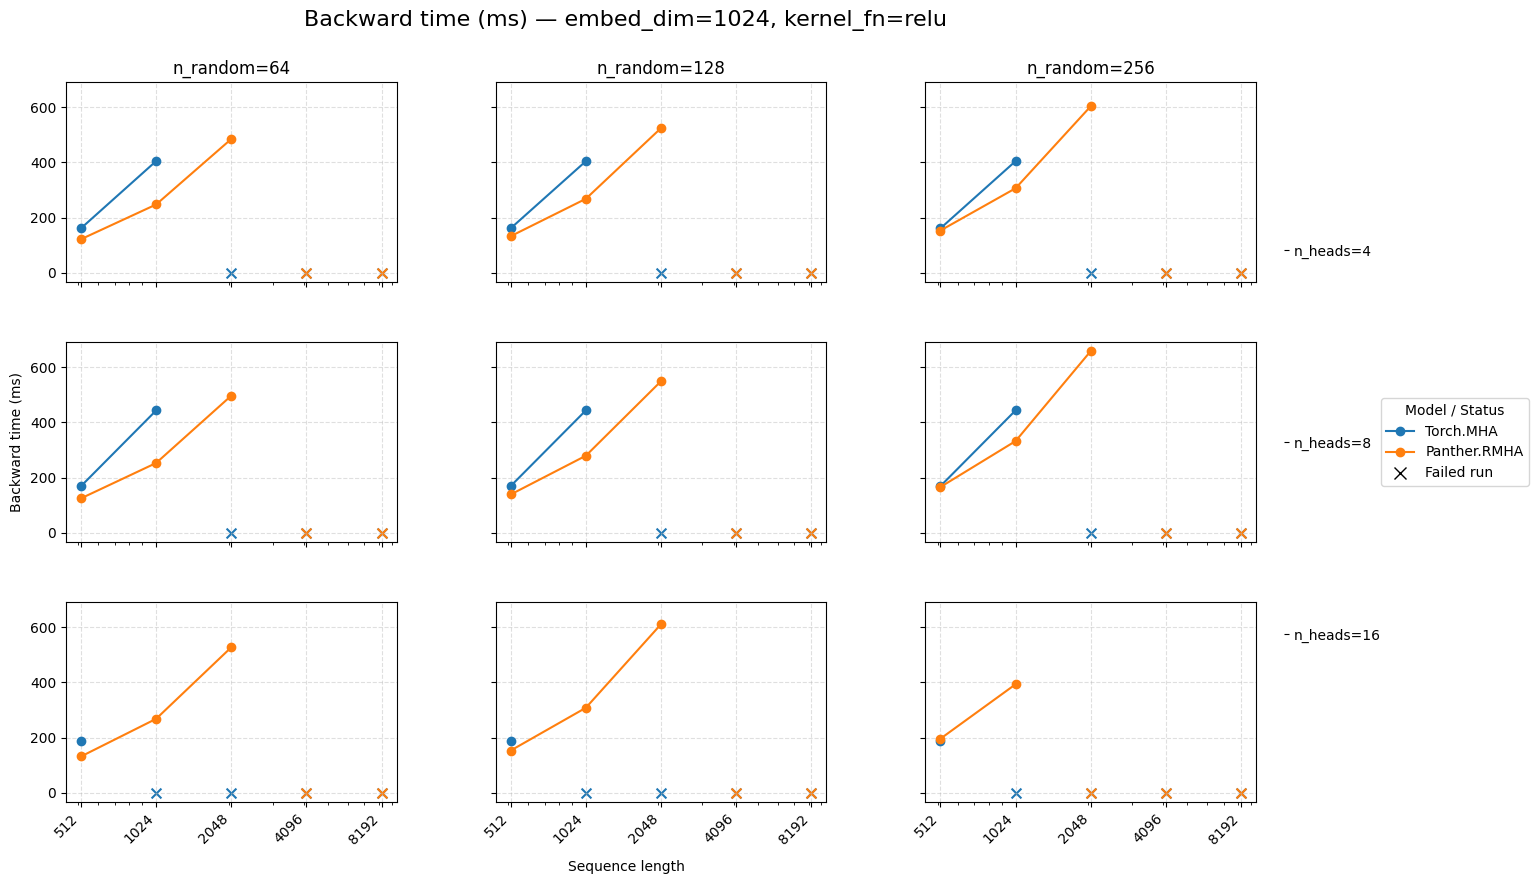

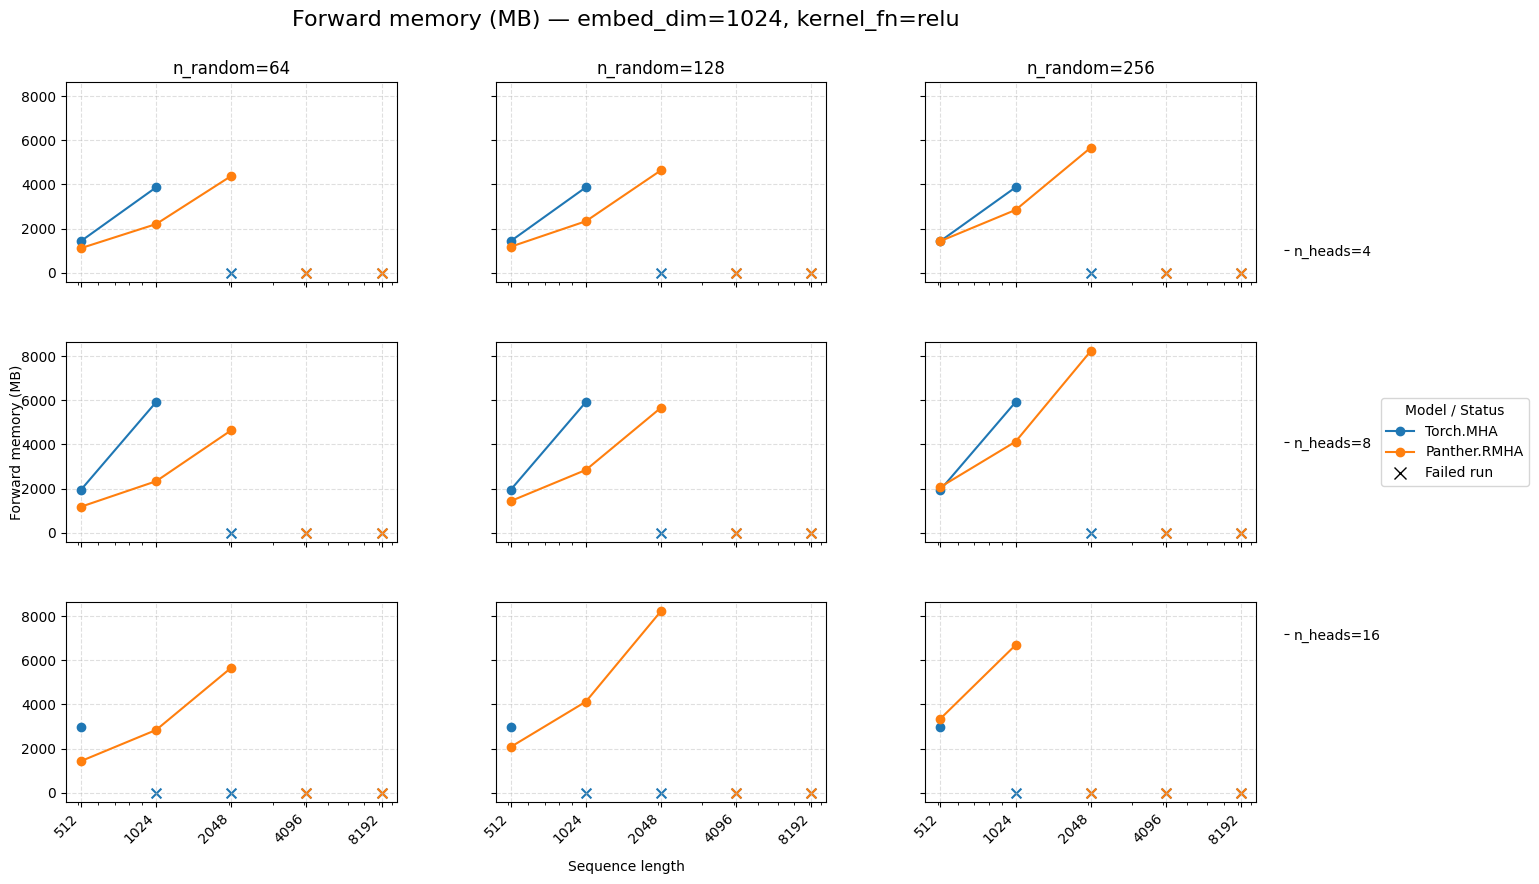

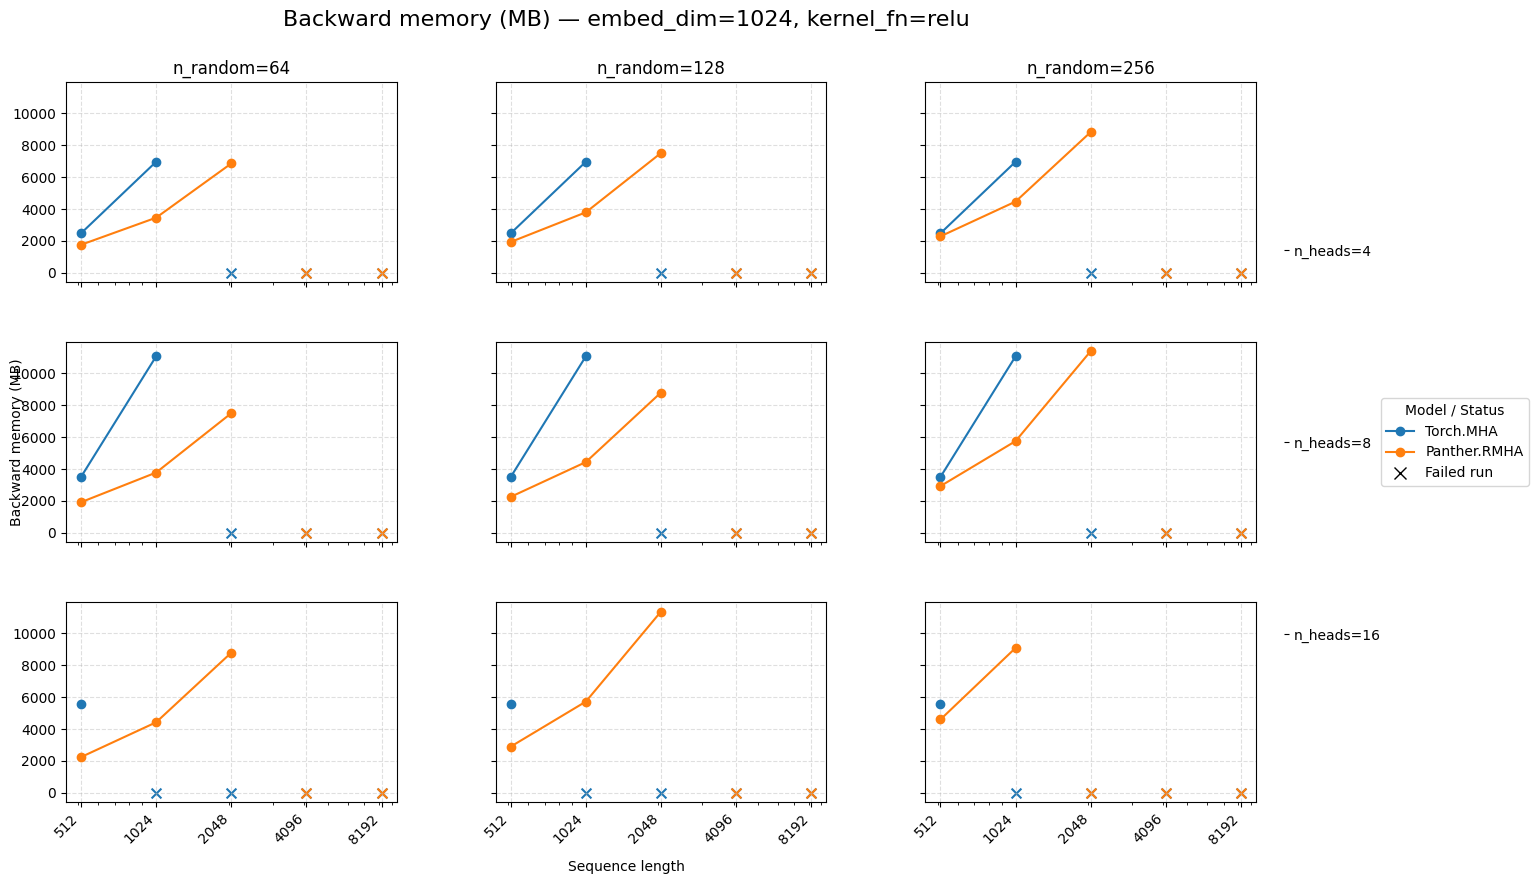

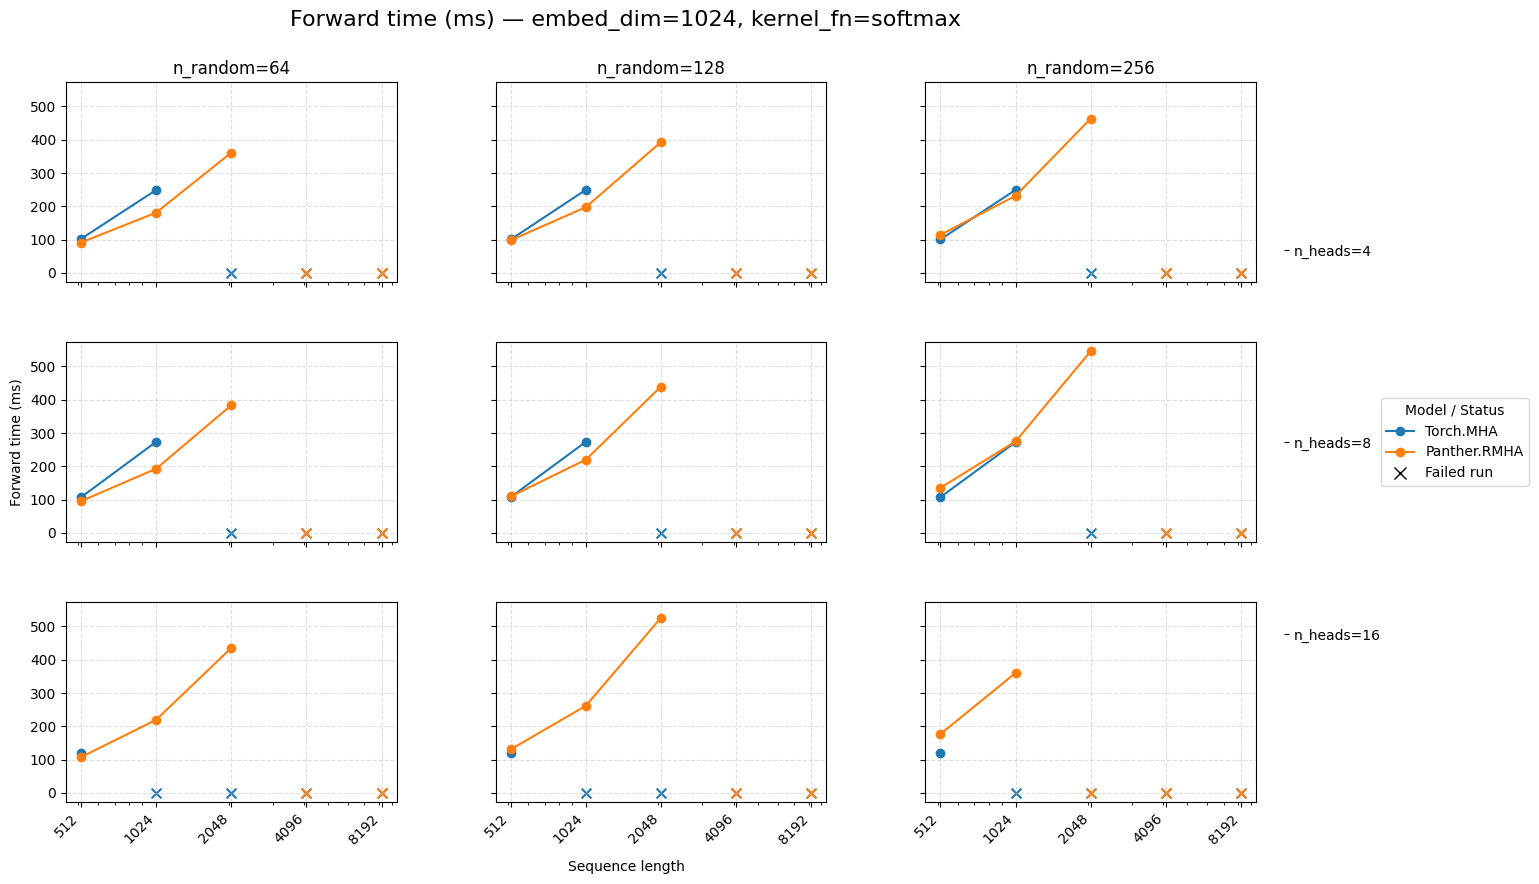

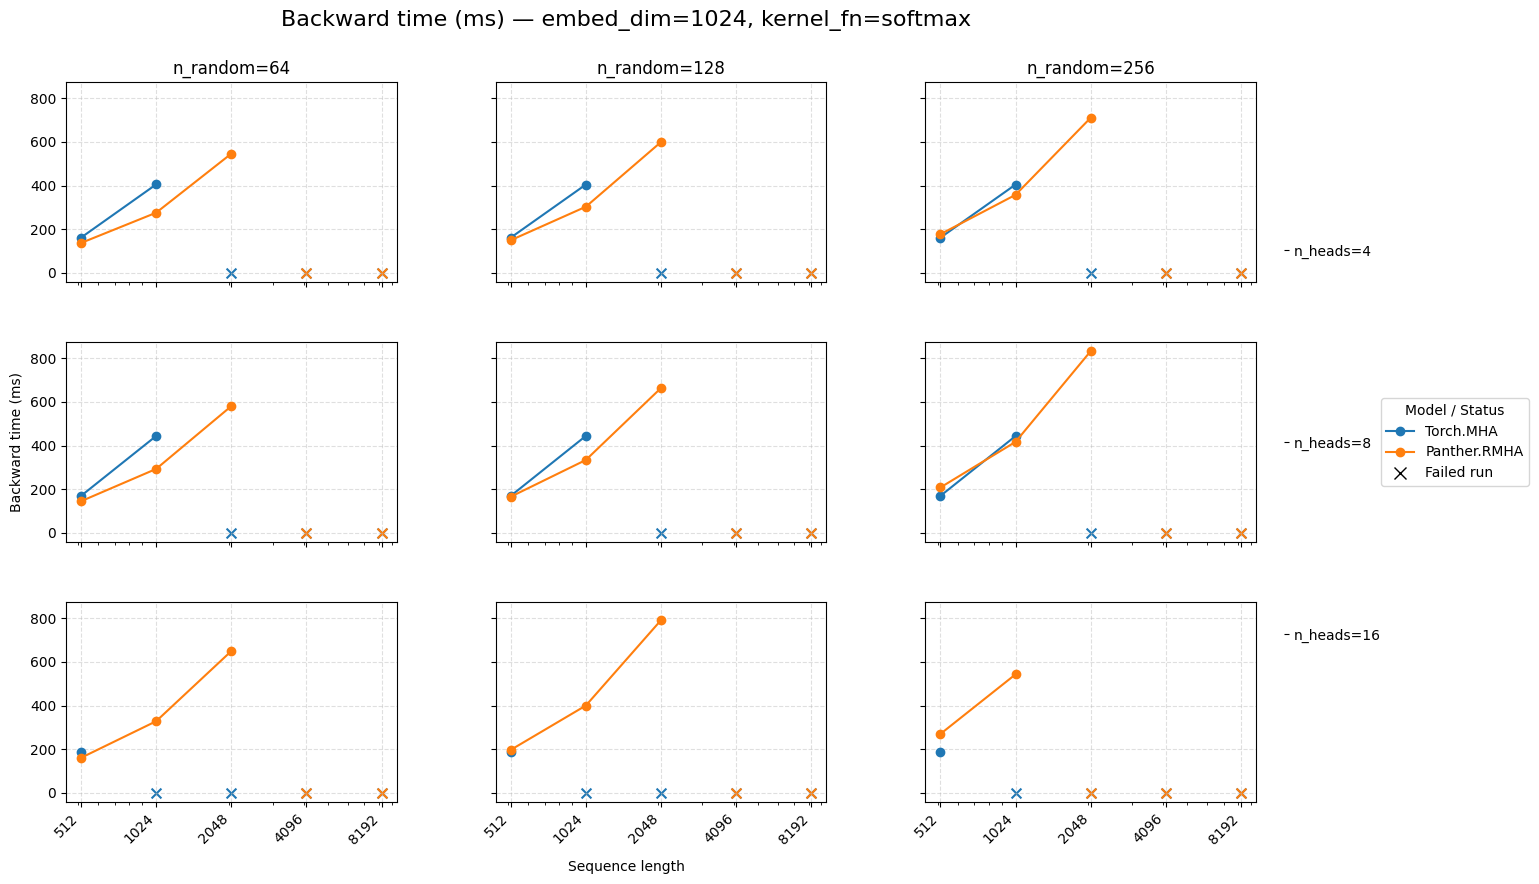

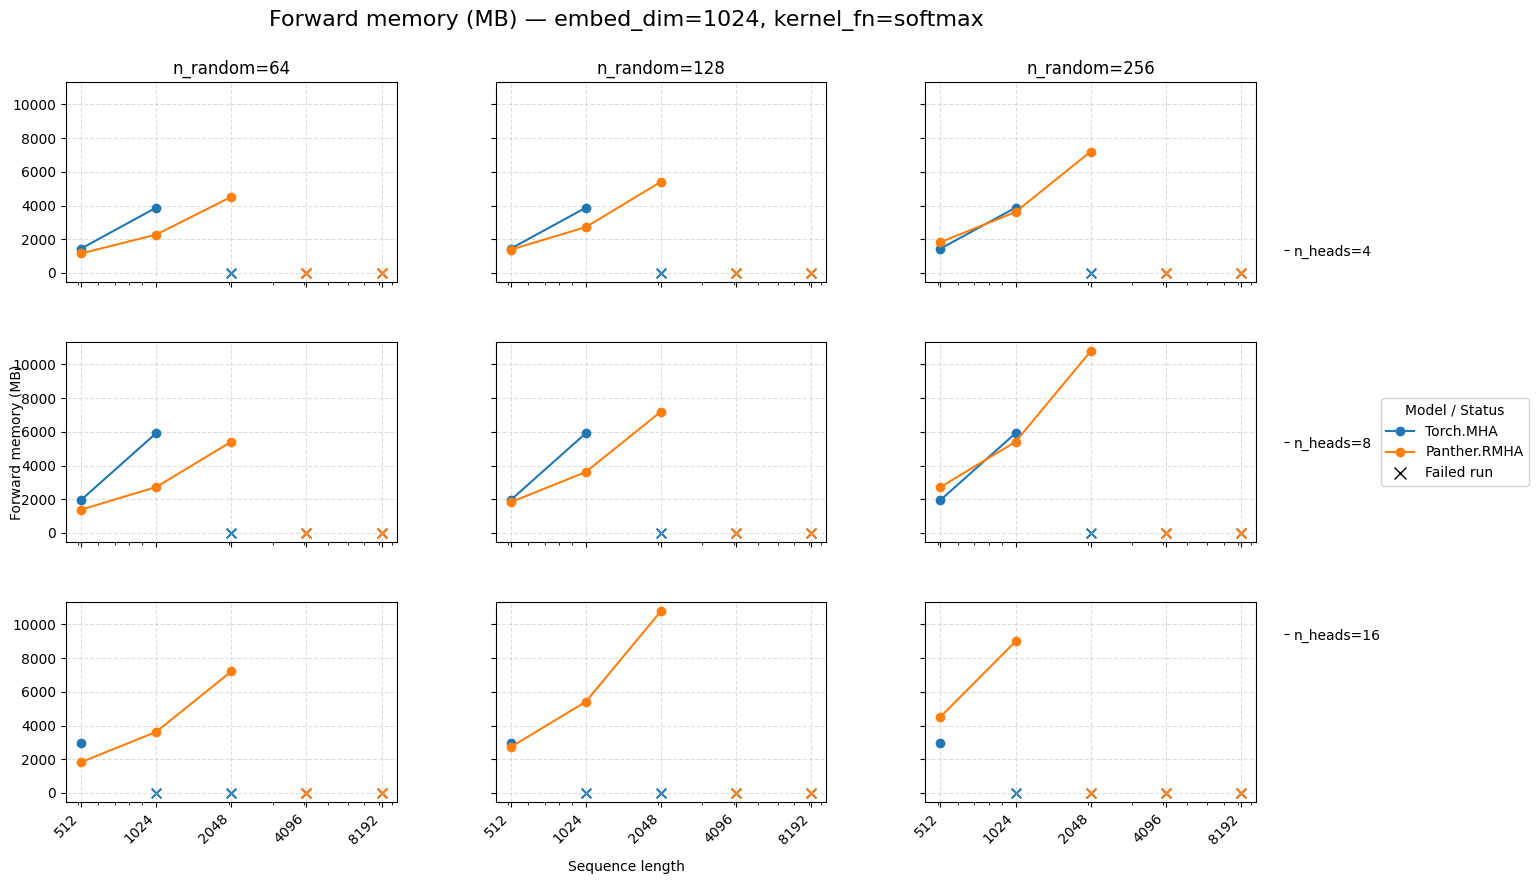

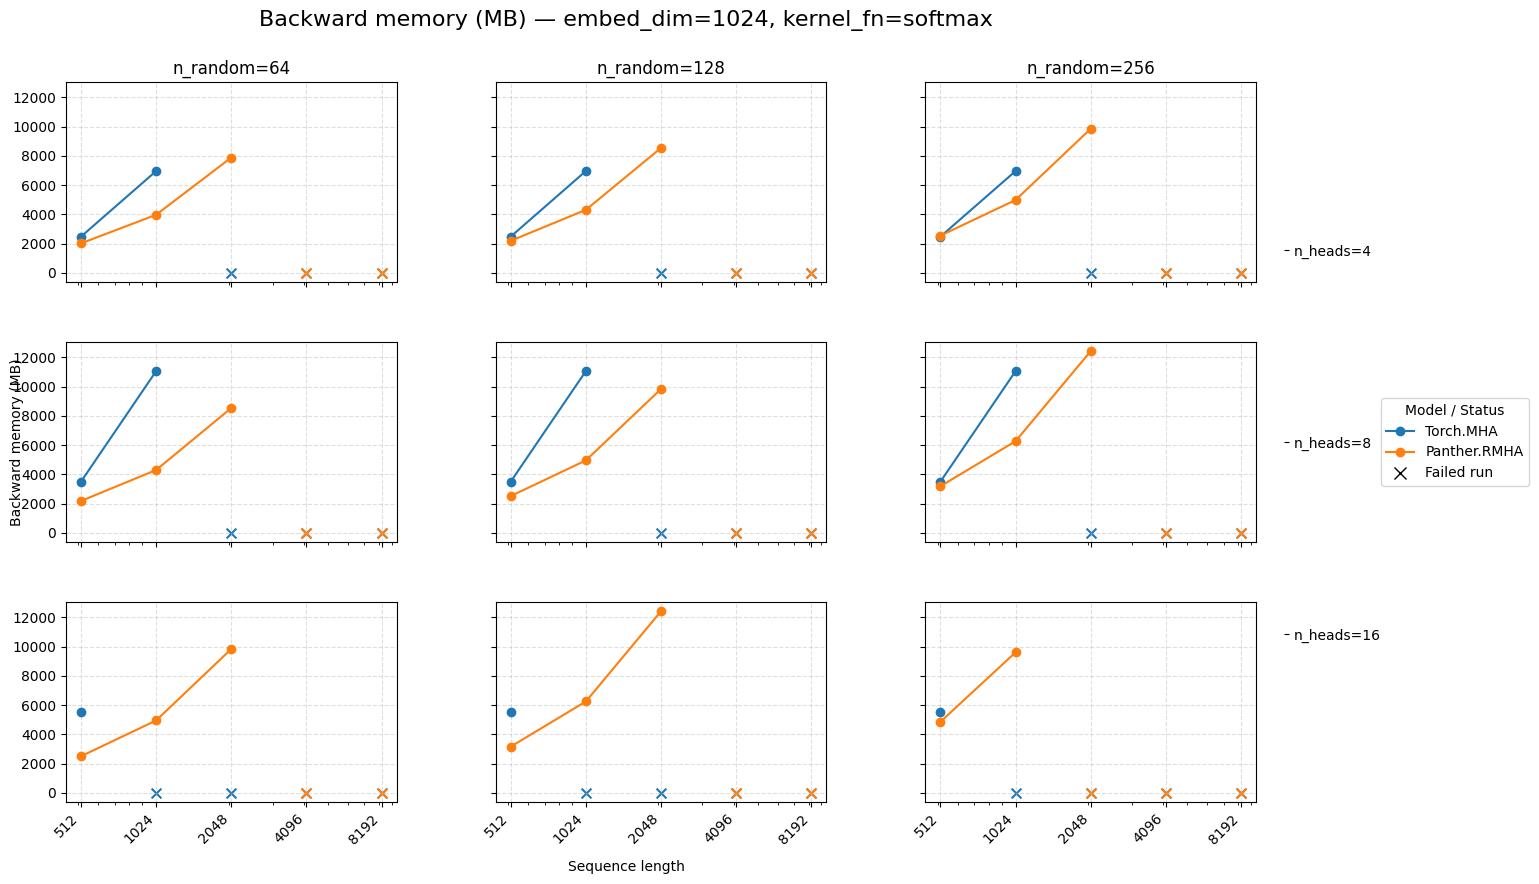

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

csv_files = [
    ("attention_benchmark_results.csv", "Torch.MHA"),
    ("rand_attention_benchmark_results.csv", "Panther.RMHA"),
]
# Toggles
use_log_x = True  # logarithmic x-axis
show_grid = True  # show grid lines

# Layout and legend tunables
layout_params = {
    "left": 0.1,
    "bottom": 0.1,
    "right": 0.95,
    "top": 0.90,
    "wspace": 0.3,
    "hspace": 0.3,
}
legend_params = {
    "loc": "center right",
    "bbox_to_anchor": (1.15, 0.5),
    "title": "Model / Status",
}

metrics = {
    "forward_mean_ms": "Forward time (ms)",
    "backward_mean_ms": "Backward time (ms)",
    "forward_memory_mb": "Forward memory (MB)",
    "backward_memory_mb": "Backward memory (MB)",
}

# ------------ READ & PREPARE DATA ------------
dfs = []
for path, label in csv_files:
    df = pd.read_csv(path)
    df["source_label"] = label
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

embed_dims = sorted(data["embed_dim"].unique())
kernel_fns = sorted(data["kernel_fn"].unique())
num_heads = sorted(data["num_heads"].unique())
num_randoms = sorted(data["num_random_features"].unique())
seq_lengths = sorted(data["seq_length"].unique())

# ------------ PLOTTING ------------
for embed in embed_dims:
    for kern in kernel_fns:
        sub = data[(data["embed_dim"] == embed) & (data["kernel_fn"] == kern)]
        if sub.empty:
            continue

        for metric, y_label in metrics.items():
            R, C = len(num_heads), len(num_randoms)
            fig, axes = plt.subplots(
                nrows=R,
                ncols=C,
                sharex=True,
                sharey=True,
                figsize=(4 * C + 2, 3 * R),
                constrained_layout=False,
            )
            fig.suptitle(
                f"{y_label} — embed_dim={embed}, kernel_fn={kern}", fontsize=16
            )

            # draw each cell
            for i, nh in enumerate(num_heads):
                for j, nr in enumerate(num_randoms):
                    ax = (
                        axes[i][j]
                        if axes.ndim > 1
                        else (axes[j] if R == 1 else axes[i])
                    )
                    cell = sub[
                        (sub["num_heads"] == nh) & (sub["num_random_features"] == nr)
                    ]

                    if cell.empty:
                        ax.set_facecolor("#f0f0f0")
                        ax.text(0.5, 0.5, "FAILED", ha="center", va="center", alpha=0.6)
                    else:
                        for label in cell["source_label"].unique():
                            part = (
                                cell[cell["source_label"] == label]
                                .set_index("seq_length")
                                .reindex(seq_lengths)
                            )
                            xs = part.index.values
                            ys = part[metric].values
                            mask = ~np.isnan(ys)
                            ax.plot(xs[mask], ys[mask], marker="o", label=label)
                            if mask.sum() < len(xs):
                                y_fill = np.nanmin(cell[metric].fillna(0)) * 0.5
                                y_missing = np.full(xs[~mask].shape, y_fill)
                                ax.scatter(xs[~mask], y_missing, marker="x", s=50)

                    if i == 0:
                        ax.set_title(f"n_random={nr}")
                    # remove per-cell y-label
                    if j == 0:
                        ax.set_ylabel("")

                    # exact seq_length ticks
                    if use_log_x:
                        ax.set_xscale("log")
                    ax.set_xticks(seq_lengths)
                    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
                    ax.set_xticklabels(seq_lengths, rotation=45, ha="right")

                    # grid only at major ticks
                    if show_grid:
                        ax.grid(
                            True, which="major", linestyle="--", alpha=0.4, axis="both"
                        )

            # shared axis labels
            fig.text(0.5, 0.02, "Sequence length", ha="center", va="bottom")
            fig.text(0.06, 0.5, y_label, va="center", rotation="vertical")

            # external n_heads axis with "n_heads=<val>" labels
            bottom, top = layout_params["bottom"], layout_params["top"]
            total_h = top - bottom
            tile_h = total_h / R
            centers = [bottom + (R - 1 - i + 0.5) * tile_h for i in range(R)]
            ext_ax = fig.add_axes(
                [layout_params["right"], bottom, 0.02, total_h], frameon=False
            )
            ext_ax.set_yticks(centers)
            ext_ax.set_yticklabels([f"n_heads={val}" for val in num_heads])
            ext_ax.yaxis.tick_right()
            for sp in ext_ax.spines.values():
                sp.set_visible(False)
            ext_ax.set_xticks([])

            # build legend with failed-run marker
            handles, labels = axes[0][0].get_legend_handles_labels()
            failed_proxy = Line2D(
                [0],
                [0],
                marker="x",
                color="black",
                linestyle="None",
                markersize=8,
                label="Failed run",
            )
            handles.append(failed_proxy)
            labels.append("Failed run")
            fig.legend(handles, labels, **legend_params)

            # apply layout tweakables
            plt.subplots_adjust(**layout_params)
            plt.show()